<a href="https://colab.research.google.com/github/Vyshnavi1412/CSM/blob/master/Traffic_signal_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 6.86 MiB/s, done.
Updating files: 100% (4/4), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [4]:
np.random.seed(0)

#loading the train.p pickle file
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

#loading the valid.p pickle file
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# loading the test.p pickle file
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)


# Splitting out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print("The dimensions of x_train is:",X_train.shape)
print("The dimensions of x_test is:",X_test.shape)
print("The dimensions of x_val is:",X_val.shape)

The dimensions of x_train is: (34799, 32, 32, 3)
The dimensions of x_test is: (12630, 32, 32, 3)
The dimensions of x_val is: (4410, 32, 32, 3)


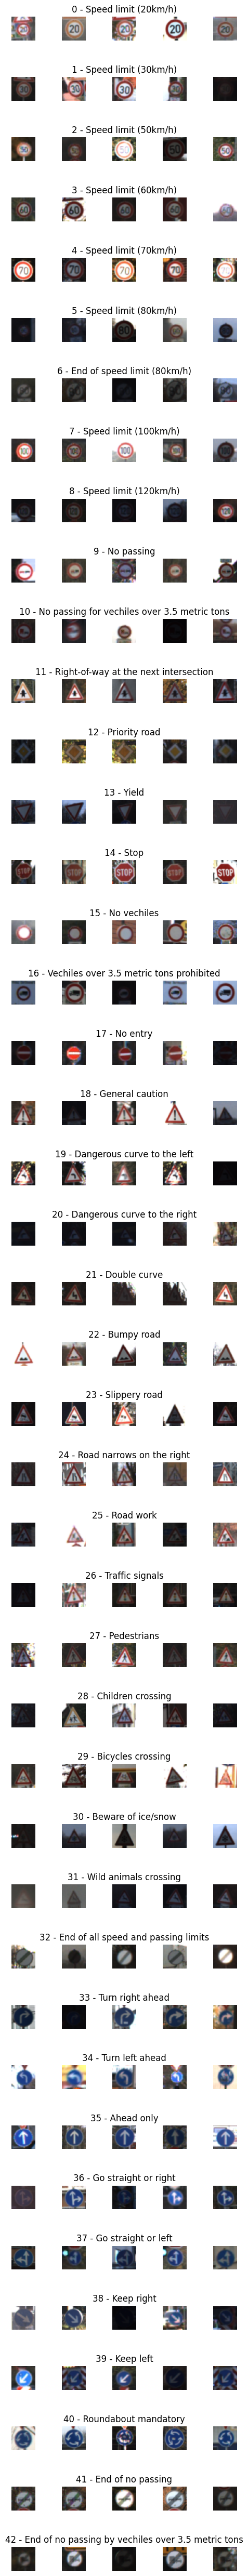

In [5]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
           axs[j][i].set_title(str(j) + " - " + row["SignName"])
           num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


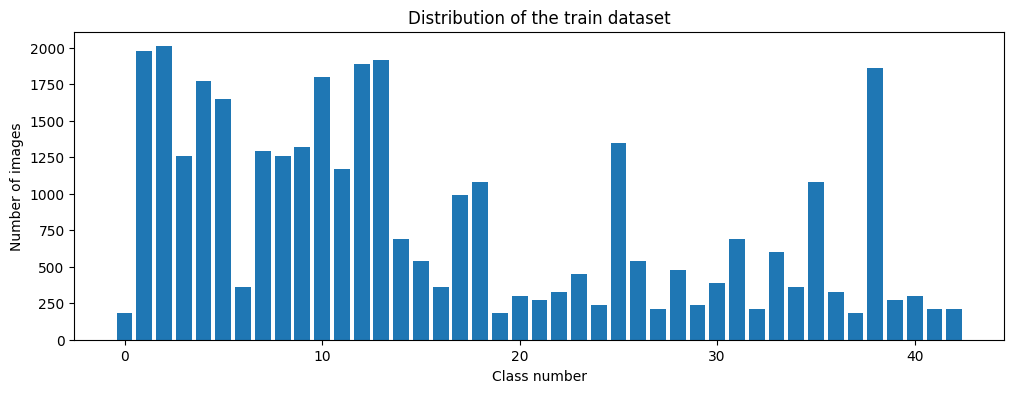

In [6]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


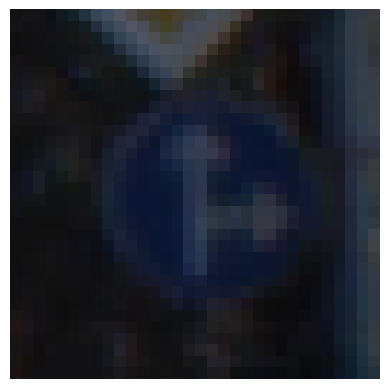

In [7]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)
(32, 32)


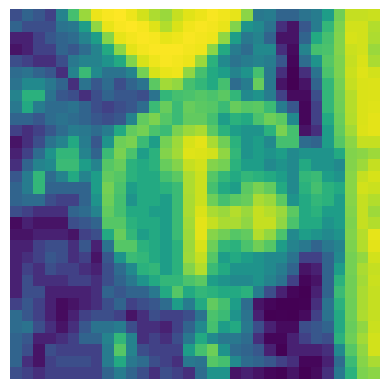

In [8]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


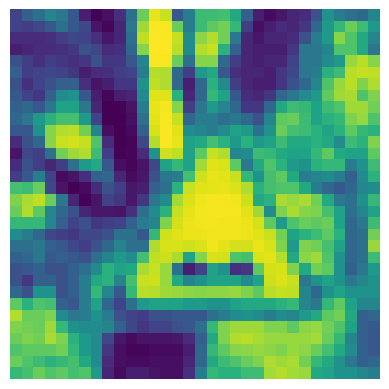

In [9]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [10]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

the X_batch shape is: (15, 32, 32, 1)


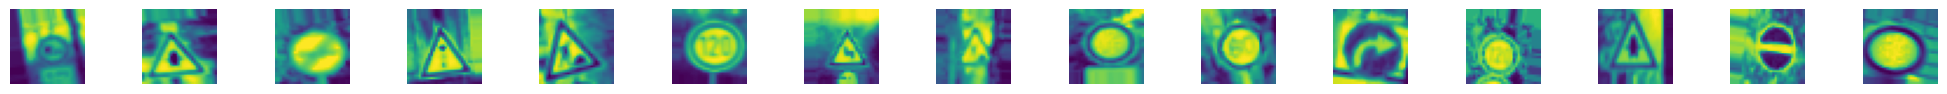

In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)


batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print("the X_batch shape is:",X_batch.shape)

In [12]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# create model

def modified_model():
   model = Sequential()
   model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(Conv2D(60, (5, 5), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(Conv2D(30, (3, 3), activation='relu'))
   model.add(MaxPooling2D(pool_size=(2, 2)))

   model.add(Flatten())
   model.add(Dense(500, activation='relu'))
   model.add(Dropout(0.5))
   model.add(Dense(43, activation='softmax'))

   model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
   return model


In [13]:
model = modified_model()
print(model.summary())

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                              steps_per_epoch=X_train.shape[0]/50,
                              epochs=30,
                              validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 60)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 30)          8130      
                                                        

<ipython-input-13-75533ca4a67e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


None
Epoch 1/30
695/695 [==============================] - 41s 30ms/step - loss: 1.8648 - accuracy: 0.4681 - val_loss: 0.3451 - val_accuracy: 0.8909
Epoch 2/30
695/695 [==============================] - 19s 27ms/step - loss: 0.5567 - accuracy: 0.8282 - val_loss: 0.1518 - val_accuracy: 0.9567
Epoch 3/30
695/695 [==============================] - 26s 38ms/step - loss: 0.3413 - accuracy: 0.8974 - val_loss: 0.0718 - val_accuracy: 0.9769
Epoch 4/30
695/695 [==============================] - 22s 32ms/step - loss: 0.2667 - accuracy: 0.9195 - val_loss: 0.0618 - val_accuracy: 0.9859
Epoch 5/30
695/695 [==============================] - 19s 28ms/step - loss: 0.2168 - accuracy: 0.9355 - val_loss: 0.0595 - val_accuracy: 0.9812
Epoch 6/30
695/695 [==============================] - 19s 28ms/step - loss: 0.1805 - accuracy: 0.9461 - val_loss: 0.0723 - val_accuracy: 0.9791
Epoch 7/30
695/695 [==============================] - 20s 29ms/step - loss: 0.1663 - accuracy: 0.9498 - val_loss: 0.0524 - val_accu

Text(0.5, 0, 'epoch')

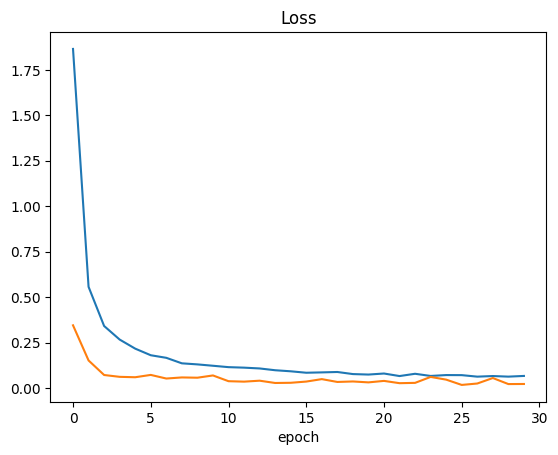

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

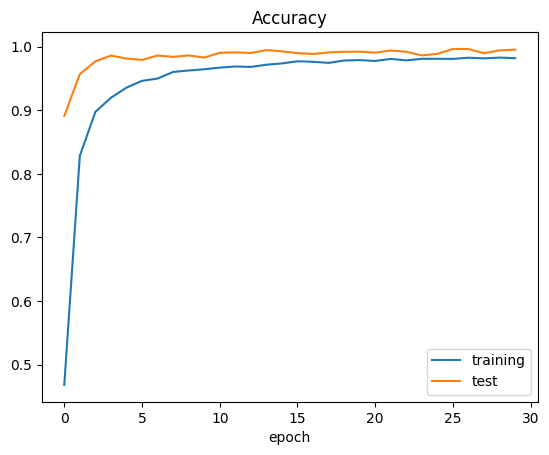

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.11423185467720032
Test accuracy: 0.9761678576469421


(32, 32)
1/1 [==============================] - 0s 296ms/step
predicted sign: 1
The detected sign is Speed limit (30km/h)


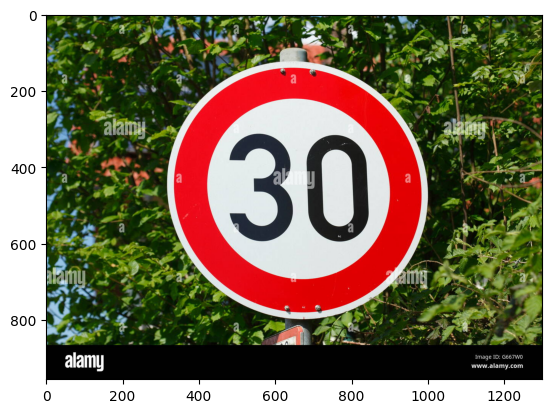

In [17]:
import requests
from PIL import Image
import csv
#slippery road sign url link
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'

#speeed limit 30kmph sign url link
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

#Yield sign url link
#url='https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
#plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

predictions=model.predict(img)
classNo=np.argmax(predictions)
print("predicted sign: "+ str(classNo))

with open('/content/drive/MyDrive/labels/labels.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    class_mapping = {int(row['ClassNo']): row['ClassName'] for row in csv_reader}

def getClassName(classNo):
    return class_mapping.get(classNo, 'Unknown Sign')

sign = getClassName(classNo)
print("The detected sign is {}".format(sign))


In [19]:
model.save('traffic_signs.keras')
